In [14]:
import torch
import torchvision
import torch.nn as nn
from torchsummary import summary

In [24]:
class YOLO(nn.Module):
	def __init__(self):
		super(YOLO, self).__init__()
		self.features = torchvision.models.vgg16(weights=True).features[:24]
		self.conv = nn.Sequential(
			nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
			nn.LeakyReLU(),
			nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
			nn.LeakyReLU(),
			nn.MaxPool2d(2),
			nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
			nn.LeakyReLU(),
			nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
			nn.LeakyReLU(),
			nn.Flatten(),
		)


		self.linear = nn.Sequential(
			nn.Linear(1024*7*7, 4096),
			nn.LeakyReLU(),
			nn.Dropout(),
			nn.Linear(4096, 30*7*7),
		)

	def forward(self, x):
		x = self.features(x)
		x = self.conv(x)
		x = self.linear(x)

		return x


In [25]:
model = YOLO()
model.to('cuda')
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
train = torchvision.datasets.VOCDetection("../../dataset/VOC2012_det", year='2012', image_set='train') # class 20개

print(train[0][1].keys())
print(train[0][1]['annotation'].keys())
print(train[0][1]['annotation']['object'][0].keys())
for key in train[0][1]['annotation']['object'][0].keys():
	print(f"{key} : {train[0][1]['annotation']['object'][0][key]}")

dict_keys(['annotation'])
dict_keys(['folder', 'filename', 'source', 'size', 'segmented', 'object'])
dict_keys(['name', 'pose', 'truncated', 'occluded', 'bndbox', 'difficult'])
name : horse
pose : Left
truncated : 0
occluded : 1
bndbox : {'xmin': '53', 'ymin': '87', 'xmax': '471', 'ymax': '420'}
difficult : 0


In [ ]:
# 0~19 까지 클래스, 20은 신뢰도, 21~24는 x,y,w,h

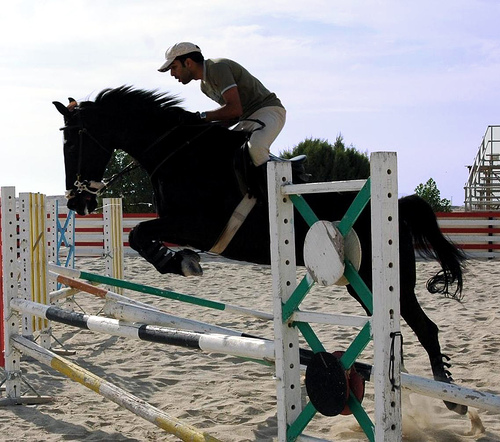

In [ ]:
train[0][0]

In [ ]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]  # (N, 1)
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # .clamp(0) is for the case when they do not intersect
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)


class YoloLoss(nn.Module):

    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        self.S = S
        self.B = B
        self.C = C

        # These are from Yolo paper, signifying how much we should
        # pay loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # predictions are shaped (BATCH_SIZE, S*S(C+B*5) when inputted
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # Take the box with highest IoU out of the two prediction
        # Note that bestbox will be indices of 0, 1 for which bbox was best
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 20].unsqueeze(3)  # in paper this is Iobj_i

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out one of the two 
        # predictions, which is the one with highest Iou calculated previously.
        box_predictions = exists_box * (
            (
                bestbox * predictions[..., 26:30]
                + (1 - bestbox) * predictions[..., 21:25]
            )
        )

        box_targets = exists_box * target[..., 21:25]

        # Take sqrt of width, height of boxes to ensure that
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_box = (
            bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 20:21]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        #max_no_obj = torch.max(predictions[..., 20:21], predictions[..., 25:26])
        #no_object_loss = self.mse(
        #    torch.flatten((1 - exists_box) * max_no_obj, start_dim=1),
        #    torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        #)

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2,),
            torch.flatten(exists_box * target[..., :20], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss


In [26]:
lr = 10**-2
optim = torch.optim.SGD(params=model.parameters(), lr=lr)

In [ ]:
epoch = 10

for epoch_cnt in range(epoch):
    